# NS3-Camera Calibration and Object Tracking

## Assets
Download assets and homework data from https://syncandshare.lrz.de/getlink/fiNisuRxdcMKkwAWrywo3ALb/NS3-Camera%20Calibration%20and%20Object%20Tracking (password is pphau22)

### Rigid Body Objects
We define rigid bodies or rigid objects as objects which do not deform, therefore, we could define the position of each vertex using a translation and a rotation (6DoF transformation) applied to the pivot of the object. Translation $t \in R^3$ and rotation $r \in SO(3)$
### Surface Representation
* Point Clouds
object surface is defined as a set of points in 3D
* Meshes
One way to define objects is as a list of vertices. To define surfaces we could define faces connceting these surfaces.
* Implicit Representation (Not covered here)
there are other ways to represent surfaces like SDF (Signed Distance Fields) or implicit representations using neural networks (NERF: Neural Radiance Fields [2]). Each representation has advantages and disatvantages depending on the operation we want to apply to it. For example pointclouds/meshes are fast to evaluate points, or traversing the surface. However, SDFs are more efficient for collision detection. [1]

### Object Scanning and Processing

In SS2 we shown objects scanned using Meshroom [4]. The final output of this software is a textured mesh that we could use for our own applications.
Note that textured meshes define color on the mesh using a UV map that will be projected to wrap the mehs surface. To simplify our setup, we could use Meshlab[3] to transfer the colors from textures to vertices, also we could apply other transformations and filters like scaling, moving the origin of the object,...etc.


Here we will use open3d [5] and show an example pointcloud/mesh loading and manipulation.

In [1]:
# required libraries
import open3d as o3d
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform.rotation import Rotation
from sklearn.metrics import mean_squared_error

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# load mesh from .ply or .obj file
# if you have a textured mesh (colors are defined using a uv map we should enable post processing enable_post_processing=True)
textured_mesh = o3d.io.read_triangle_mesh('assets/models/oats/texturedMesh_alligned.obj', enable_post_processing=True)
print(f" is textured? {textured_mesh.has_textures()}. has vertex colors? {textured_mesh.has_vertex_colors()}. num_vertices = {len(textured_mesh.vertices)}. num_faces(triangles) = {len(textured_mesh.triangles)}")
# visualize the data (blocking)
o3d.visualization.draw_geometries([textured_mesh])

[Open3D INFO] Skipping non-triangle primitive geometry of type: 2
 is textured? True. has vertex colors? False. num_vertices = 376811. num_faces(triangles) = 688594


In [3]:
mesh = o3d.io.read_triangle_mesh('assets/models/oats/texturedMesh_alligned_vertex_color.ply')
print(f" is textured? {mesh.has_textures()}. has vertex colors? {mesh.has_vertex_colors()}. num_vertices = {len(mesh.vertices)}. num_faces(triangles) = {len(mesh.triangles)}")
object_transform = np.eye(4)
object_transform[:3,:3] = Rotation.from_euler('xyz',[45,0,90], degrees=True).as_matrix()
object_transform[:3, 3] = [1,2,4]
# add axis coordinate frame (xyz - rgb)
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0,0,0])
mesh.transform(object_transform)
mesh_frame.transform(object_transform)

# visualize the data (blocking)
o3d.visualization.draw_geometries([mesh, mesh_frame])

 is textured? False. has vertex colors? True. num_vertices = 344438. num_faces(triangles) = 688606


In [4]:
# Processing point clouds
pcd = o3d.io.read_point_cloud('assets/models/oats/texturedMesh_alligned_vertex_color.ply')
'''
# To convert from a trimesh:  (if you have a textured meshmake sure to transfer texture color to vertex color using Meshlab filters)
assert mesh.has_vertex_colors
pcd = o3d.geometry.PointCloud()
pcd.points=mesh.vertices
pcd.colors=mesh.vertex_colors
'''
voxel_down_sampled_pcd = o3d.geometry.PointCloud(pcd).voxel_down_sample(voxel_size=0.001).translate([1,0,0])
print(f"voxel_down_sampling: num points before downsampleing is {len(pcd.points)}, after is {len(voxel_down_sampled_pcd.points)}")

uniform_down_sampled_pcd = o3d.geometry.PointCloud(pcd).uniform_down_sample(every_k_points=10).translate([2,0,0])
print(f"num points before downsampleing is {len(pcd.points)}, after is {len(uniform_down_sampled_pcd.points)}")


scaled_pcd = o3d.geometry.PointCloud(pcd).scale(0.4, pcd.get_center()).translate([3,0,0])

o3d.visualization.draw_geometries([pcd, voxel_down_sampled_pcd, uniform_down_sampled_pcd, scaled_pcd])

voxel_down_sampling: num points before downsampleing is 344438, after is 344073
num points before downsampleing is 344438, after is 34444


## ICP (Iteractive Closest Point)
Since, we use depth sensors as the base for this course, we also have access to depth data for every frame, and as a result an oriented pointcloud from aligned depth and color images. Therefore, we could use ICP algorithms this would allow us to utilize depth information to allign pointcloud.


### Steps:
#### Initial Conditions:
We assume that we have 2 point clouds $P_{source}, Q_{target}$ and we want to register the source to the target by finding a rigid body transformation from source to target$T = [R|t]$. We assume that the rotation and translation between the the two pointclouds is small.

#### Matching
Every iteration, we find a set of $m$ correpondences ${(u_1,v_1), (u_2,v_2), ...}$ where $p_{u_i} \in P_{source}$ and $q_{v_i} \in Q_{target}$. 
The matches are selected bsaed on some cretirion. The simplest is to match based on the closest distance. Additionally, we could ignore outliers where the distance closest point distance is larger than a given threshold. 

We define the list of points $P_{source}^{inliers} = \{p_{u_1}, ..., p_{u_m}\}$ and $Q_{target}^{inliers} = \{q_{v_1}, ..., q_{v_m}\}$ 

#### Transformation Estimation Loss Minimization
Our goal is to find $$T^* = argmin_{T} || Q_{target}^{inliers} - P_{source}^{inliers} \times T  ||_2^2$$
Where T = [R|t]. Since $R \in SO(3)$ we need a constrained optimization scheme to guarantee that R is a valid rotation matrix (or a valid rotation representation in general Quaternion, AxisAngle,..). Finding $t$ is 
For more technichal details you could check [6]

### Evaluation Metrics

* Visually we could visualize the transformed source point cloud and target to assist the quality of the result.
* Quantitatively 2 metrics are used to evaluate the quality of the solution $T$
    * Inlier RMSE root mean squared error for the correspondences (the lower the better) $RMSE_{inlier} =  \sqrt{\frac{|| Q_{target}^{inliers} - P_{source}^{inliers} \times T  ||_2^2}{m}}$
    * $Fitness = \frac{m}{|Q_{target}|}$ (the higher the better) 

### Variations:
### Point to Point ICP
The approach we followed above is a point to point ICP. $$T^* = argmin_{T} || Q_{target}^{inliers} - P_{source}^{inliers} \times T  ||_2^2$$
### Point to Plane ICP
The minimization objective here aims to push points the surface plane of the target point cloud, by minimizing the source point to target plane distance.
This is done using the target point cloud normal vectors. $p_{u_i}$ belongs to the plane around 
$q_{v_i}$ if the dot product $(R \times p_{u_i} + t - q_{v_i})n_{v_i} = 0$

$N_{targe}^{inliers} = \{ \vec n_{v1},...,n_{v_m} \}$

$$T^* = argmin_{T} || (Q_{target}^{inliers} - P_{source}^{inliers} \times T) \times N_{target}^{inliers}  ||_2^2$$



For more details you could check [5],[6] or [link](http://www.open3d.org/docs/latest/tutorial/t_pipelines/t_icp_registration.html)

In [5]:
import open3d as o3d
import numpy as np
import cv2
from sklearn.metrics import mean_squared_error
from scipy.spatial.transform.rotation import Rotation
# read source point cloud
pcd_source = o3d.io.read_point_cloud('assets/models/oats/texturedMesh_alligned_vertex_color.ply')
pcd_source = pcd_source.voxel_down_sample(0.005)
# visualize the source point cloud
o3d.visualization.draw_geometries([pcd_source])
# create a mock target point cloud as a toy example
points = np.array(pcd_source.points)
extents = points.max(axis=0) - points.min(axis=0)
print(extents)
translation = 0.05 * extents
transform = np.eye(4)
transform[:3,3] = translation
pcd_target = o3d.geometry.PointCloud(pcd_source)
transform[:3,:3] = Rotation.from_euler('xyz', [25,0,0], degrees=True).as_matrix()
transform[:3,3] = [0,0,0.1]
pcd_target.transform(transform)

# set color for source to red and target to blue (later solution is green)
pcd_source.paint_uniform_color([1,0,0])
pcd_target.paint_uniform_color([0,1,0])

o3d.visualization.draw_geometries([pcd_source, pcd_target])

# Note it is better to run iCP once with ICPConvergenceCriteria(max_iteration=num_iteration) but here we want to visualize each step.
num_iterations = 30
initial_transformation = np.eye(4)
threshold = 0.05 * max(extents)
vis = o3d.visualization.Visualizer()
vis.create_window()
ctr = vis.get_view_control()
ctr.set_lookat([0, 0, 0])
pcd_solution = o3d.geometry.PointCloud(pcd_source)
pcd_solution.paint_uniform_color([0,0,1])
geometries = [pcd_source, pcd_target, pcd_solution]
o3d.visualization.draw_geometries(geometries)
cumulative_transformation = np.eye(4)
errors = []
errors2 = []
for iteration in range(num_iterations):
    reg_p2p = o3d.pipelines.registration.registration_icp(
                    pcd_solution, pcd_target, threshold, initial_transformation,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(),
                o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1),)
    
    solution_transform = reg_p2p.transformation
    cumulative_transformation = cumulative_transformation @ solution_transform
    diff = (np.array(pcd_solution.points) - np.array(pcd_target.points))
    # exact_rmse = np.mean(np.sum(diff ** 2, axis=1)**0.5)
    exact_rmse = mean_squared_error(np.array(pcd_solution.points), np.array(pcd_target.points), squared=False)
    errors.append(exact_rmse) # calculation could be slightly different from rmse in open3d
    errors2.append(reg_p2p.inlier_rmse)
    print(f"Iteration registration errors: Inlier MSE is {reg_p2p.inlier_rmse}, Inlier Fitness is {reg_p2p.fitness}")
    print(f"RMSE(same object) = {exact_rmse}")
    print(f"cumulative translation = {cumulative_transformation[:3,3]} cumulative rotation = {Rotation.from_matrix(cumulative_transformation[:3,:3]).as_euler('xyz', degrees=True)}")
    initial_transformation = solution_transform
    pcd_solution = pcd_solution.transform(solution_transform)
    if iteration%5 == 0:
        o3d.visualization.draw_geometries(geometries)


plt.plot(np.arange(num_iterations), errors)
plt.plot(np.arange(num_iterations), errors2)

plt.xlabel('num iterations')
plt.ylabel('error(RMSE)');

[0.77433877 0.78793649 1.50860303]
Iteration registration errors: Inlier MSE is 0.04317638315654221, Inlier Fitness is 0.26397975826506503
RMSE(same object) = 0.19948505394046923
cumulative translation = [0.00054199 0.01852425 0.00673761] cumulative rotation = [-0.89804054 -0.02515301  0.09150917]
Iteration registration errors: Inlier MSE is 0.04112175124982255, Inlier Fitness is 0.30274540933079486
RMSE(same object) = 0.1982178458748994
cumulative translation = [0.00104507 0.05382027 0.01899672] cumulative rotation = [-2.47771774 -0.08908557  0.28080563]
Iteration registration errors: Inlier MSE is 0.038290566842299846, Inlier Fitness is 0.3442707332047553
RMSE(same object) = 0.19540547651839169
cumulative translation = [0.00066772 0.10017058 0.03452181] cumulative rotation = [-4.31189848 -0.20366529  0.55579727]
Iteration registration errors: Inlier MSE is 0.03758221611088422, Inlier Fitness is 0.38756968949029774
RMSE(same object) = 0.190971340920563
cumulative translation = [-0.000

KeyboardInterrupt: 

## Multiview Camera Calibration
### Motivation

In a simplified setup where we deal only with Rigid body objects, Hand-Object interactions are subject to different types of occlusion Hand-Hand occlusion, self-occlusion, and Hand-Object occlusion. These types of occlusions increase the difficulty of detection and pose estimation tasks.

Multiple approaches exist to overcome this issue. One of them is data-driven statistical priors, where a machine learning model learns to hallucinate the occluded parts of the interaction object or hand keypoints.

Another solution is to record data in multiple views and fuse them into one world coordinate system. Therefore it is required to estimate the relative camera pose with respect to the world coordinate system. 
Note: Usually, the world coordinate system is either one of the cameras or defined with respect to each of them, for example, the center of the table in the tabletop setup. In general, if we have $K$ views, we need $K$ rigid body transformation matrices.

We learned in the previous lecture about camera intrinsics and stereo extrinsics. In this lecture, we will focus on camera-camera extrinsics.  

### Calibration Process
In our setup we will use the tools provided by opencv to calibrate different views using a checkerboard


### Finding Correspondences (SIFT points)
How to find correspondences between two images for the same object from different camera angles. 
We could extract SIFT feature points and match the keypoints in images based on descriptors similarity.

#### Homography (Application for SIFT points)
Given two images $I_1, I_2$ for a textured planar surface (for example, a chessboard, or a table surface with a pattern on it). 
Define each plane on the surface by a set of feature points $P_1, P_2$.
Homography is a structure perserving transformation (In our case we are interested in finding 6DoF rigid body transformation) as this will correspond to the relative  transformation between two camera poses.

In [ ]:
# https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html
import numpy as np
import cv2
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
img1 = cv2.imread('assets/image1.png',0)          # queryImage
img2 = cv2.imread('assets/image2.png',0)          # trainImage
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [ ]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


In [ ]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
               
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
fig=plt.figure(figsize=(20,20))
plt.imshow(img3, 'gray');

## RANSAC (RANdom SAmple Consensus)


In [ ]:
import sklearn.linear_model as linear_model
np.random.seed(123)
# generate points    
num_points = 50
alpha = 0.6
beta = np.random.normal(0.0, 0.03, size=(num_points,1))


X = np.linspace(0, 1.0, num_points).reshape(num_points,1)
Y = alpha * X + beta

# randomly create outliers
inlier_ratio = 0.8
outlier_ratio = 1-inlier_ratio

inlier_mask = np.random.choice([True, False], size=(num_points,), p=[inlier_ratio, outlier_ratio])
outlier_mask = ~inlier_mask
Y[outlier_mask] += np.random.normal(1,1)

plt.scatter(X[inlier_mask],Y[inlier_mask], color='blue', label='inliers')
plt.scatter(X[outlier_mask],Y[outlier_mask], color='red', label='outliers')
# print(X.shape, Y.shape)
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X , Y)
# print(X.shape, linear_regression.coef_.shape, linear_regression.intercept_.shape)
plt.plot(X, linear_regression.predict(X), label="linear regression")

ransac_linear_regression = linear_model.RANSACRegressor()
ransac_linear_regression.fit(X, Y)

plt.plot(X, ransac_linear_regression.predict(X), label="ransac linear regression")

plt.legend()
plt.title('Linear Regression vs Ransac Linear Regression');

### Perspective N – points problem (PnP) 
* Given $N$ 3D points in the world coordinate system $P_w \in \mathbb{R}^{N \times 3}$.
* You are given 2 different views with a caliberated camera intrinsics $K\in \mathbb{R}^{3 \times 3}$) with the 2D pixel correspondence of the previous $N$ points $p_{c}, p_{c} \in \mathbb{R}^{N \times 2}$
* Find the relative rotation and translation between the two camera views $[R|t] \in \mathbb{R}^{4x3}$.
* The perpective projection is formulated as follows using homogeneous coordinates
$$\overline{p_c} = K \times [R|t] \times \overline{P_w}$$
$$ \overline{P_w} = (x_{P_w}, y_{P_w}, z_{p_w}, 1)^T$$
$$ p_c = (u, v) = \frac{X_{p_c}} {Z_{p_c}} , \frac{Y_{p_c}}{Z_{p_c}} $$ 
* We could use RANSAC to have a more robust estimation using `cv2.solvePnPRansac`.

### Camera Pose Estimation
* We could use `cv2.calibrateCamera` or `cv2.solvePnP` (does not use RANSAC) along with the checkerboard pattern to calibrate multiple views.
* scripts/multiview.py contains a visualization of the aligned pointclouds based on checkerboard calibration.
* Note that in the more general case we could estimate the distortion polynomial ceffecients $D$ and intrinsics $K$.
* Our goal is to minimize the reprojection error which is mean squared error between 2D correspondences and the perspective projection of the 3D correspondences.
* The default 

## SLAM using D435i
* SLAM is short for Self Localization And Mapping
* The algorithm tries to simultanously
    * Build a map for the envionment
    * Estimate the trajectory of the camera with repsect to the environment
* Realsense provides an integration with opensource ros package for SLAM.
* Utilizes RGBD + IMU data in the D435i
* Ego-Perspective Setup could utilize the SLAM algorithm available in [realsense ros-wrapper](https://github.com/IntelRealSense/realsense-ros/blob/development/realsense2_camera/launch/opensource_tracking.launch) 
* You could use the D435i open source tracking in ros

```sh
roslaunch realsense2_camera opensource_tracking.launch
```
* Chcek [7] for more details.

## Homework (ICP Tracker)
* Workload 4 students
* Deadline due in 1 week
* The goal of this homework is to apply ICP between a point cloud from a scanned model (source) and a a point cloud from realsense recording (ros wrapper bag).
#### 1. Loading the Model
* Load the point cloud for the oats can using `open3d`
* Downsample the pointcloud using voxel downsampling (set voxel size to 0.01)
* Resulting output should looks as follow 

<img src="assets/homework/images/downsampled_pcd.png" width=300 title="Downsampled Model Pointcloud" />

In [2]:
# required libraries
# !pip install open3d
import open3d as o3d
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform.rotation import Rotation
from sklearn.metrics import mean_squared_error
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Load the point cloud for the oats can using open3d
pcd = o3d.io.read_point_cloud('assets/models/oats/texturedMesh_alligned_vertex_color.ply')

# Downsample the pointcloud using voxel downsampling (set voxel size to 0.01)
voxel_down_sampled_pcd = o3d.geometry.PointCloud(pcd).voxel_down_sample(voxel_size=0.01).translate([1,0,0])

# visualize the down sampled model
o3d.visualization.draw_geometries([voxel_down_sampled_pcd])

#### 2. Loading the realsense sequence
* Read the color, depth, and camera info topics from the rosbag using `pyrosbag` library. 
* It is enough to use the first 50 color and first depth frames.
* use `o3d.geometry.PointCloud.create_from_rgbd_image` to create a point cloud
* Resulting output should looks as follow 

<img src="assets/homework/images/realsense_pcd.png" width=300 title="Realsense Point Cloud" />

In [4]:
import rosbag
from scripts.load_ros_bag import load_sequence

bagfile = "assets/homework/icp_tracking_oats.bag"
data, ret = load_sequence(bagfile)

color_topic = '/camera/color/image_raw'
depth_topic = '/camera/aligned_depth_to_color/image_raw'
color_camera_info_topic = '/camera/color/camera_info'
depth_camera_info_topic = '/camera/aligned_depth_to_color/camera_info'
color_image = []
depth_image = []

# It is enough to use the first 50 color and first depth frames.
for i in range(50):
    color_image.append(data[i][color_topic]['msg'])
    depth_image.append(data[i][depth_topic]['msg'])
    camera_info = data[i][color_camera_info_topic]['msg']
print(camera_info)

header: 
  seq: 954
  stamp: 
    secs: 1650365556
    nsecs: 489573002
  frame_id: "camera_color_optical_frame"
height: 480
width: 640
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [606.7113037109375, 0.0, 320.8851623535156, 0.0, 605.7533569335938, 244.3988800048828, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [606.7113037109375, 0.0, 320.8851623535156, 0.0, 0.0, 605.7533569335938, 244.3988800048828, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 0
binning_y: 0
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: False


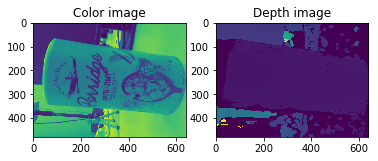

In [6]:
# use o3d.geometry.PointCloud.create_from_rgbd_image to create a point cloud
color_image_init = o3d.geometry.Image(np.ascontiguousarray(color_image[0]).astype(np.uint8))
depth_image_init = o3d.geometry.Image(np.ascontiguousarray(depth_image[0]).astype(np.float32))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_image_init, depth_image_init)

plt.subplot(1, 2, 1)
plt.title('Color image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [7]:
intrinsics = o3d.camera.PinholeCameraIntrinsic(width=640, height=480, fx= 606.7113037109375, fy= 605.7533569335938, cx=320.8851623535156, cy=244.3988800048828)
pcd_target = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)
# pcd_target = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, o3d.camera.PinholeCameraIntrinsic(
        # o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# print(np.asarray(pcd_target.points))
# o3d.visualization.draw_geometries([pcd_target])

#### 3. Pose Initialization

* Use `o3d.visualization.VisualizerWithEditing` following the [tutorial](http://www.open3d.org/docs/latest/tutorial/visualization/interactive_visualization.html?highlight=visualizerwithediting) to get correspondences between the realsense pointcloud and the oats can model pointcloud.
* Find a rigid body transformation and scale for the initial pose using `open3d.pipelines.registration.TransformationEstimationPointToPoint`
    
<img src="assets/homework/images/oats_correspondences.png" title="Picking Model Correspondences" width=200 /> 

<img src="assets/homework/images/realsense_correspondences.png" title="Realsense Correspondences" width=200 />
* Allign the model pointcloud to the realsense pointcloud, and visualize the allignment

<img src="assets/homework/images/model_pcd_allignemtn.png" title="Aligned Output" />

In [8]:
pcd_source = voxel_down_sampled_pcd

# points = np.array(pcd_source.points)
# extents = points.max(axis=0) - points.min(axis=0)
# print(extents)
# translation = 0.05 * extents
# transform = np.eye(4)
# transform[:3,3] = translation
# pcd_target = o3d.geometry.PointCloud(pcd_source)
# transform[:3,:3] = Rotation.from_euler('xyz', [25,0,0], degrees=True).as_matrix()
# transform[:3,3] = [0,0,0.1]
# pcd_target.transform(transform)

# set color for source to red and target to blue (later solution is green)
# pcd_source.paint_uniform_color([1,0,0])
# pcd_target.paint_uniform_color([0,1,0])

In [9]:
def pick_points(pcd):
    print("")
    print(
        "1) Please pick at least three correspondences using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) After picking points, press 'Q' to close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

In [11]:
# pick points from two point clouds and builds correspondences
picked_id_source = pick_points(pcd_source)
picked_id_target = pick_points(pcd_target)
assert (len(picked_id_source) >= 3 and len(picked_id_target) >= 3)
assert (len(picked_id_source) == len(picked_id_target))
corr = np.zeros((len(picked_id_source), 2))
corr[:, 0] = picked_id_source
corr[:, 1] = picked_id_target


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] Picked point #18272 (0.79, -0.37, -0.88) to add in queue.
[Open3D INFO] Picked point #25612 (0.6, -0.26, -1.1) to add in queue.
[Open3D INFO] Picked point #15855 (0.51, 0.066, -0.82) to add in queue.


1) Please pick at least three correspondences using [shift + left click]
   Press [shift + right click] to undo point picking
2) After picking points, press 'Q' to close the window
[Open3D INFO] Picked point #160664 (-0.012, 0.025, 0.2) to add in queue.
[Open3D INFO] Picked point #105050 (-0.029, -0.0044, 0.19) to add in queue.
[Open3D INFO] Picked point #46837 (0.0038, -0.042, 0.21) to add in queue.



In [12]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [13]:
# estimate rough transformation using correspondences
print("Compute a rough transform using the correspondences given by user")
p2p = o3d.pipelines.registration.TransformationEstimationPointToPoint(with_scaling=True)
trans_init = p2p.compute_transformation(pcd_source, pcd_target,
                                        o3d.utility.Vector2iVector(corr))

# point-to-point ICP for refinement
print("Perform point-to-point ICP refinement")
threshold = 0.03  # 3cm distance threshold
reg_p2p = o3d.pipelines.registration.registration_icp(
    pcd_source, pcd_target, threshold, trans_init, o3d.pipelines.registration.TransformationEstimationPointToPoint())
draw_registration_result(pcd_source, pcd_target, reg_p2p.transformation)
print("")

Compute a rough transform using the correspondences given by user
Perform point-to-point ICP refinement



#### 4. Pose Tracking

* Iterate over the color and depth frames each timestep and run ICP to refine the previous model pose (use the previous pose as initial pose).
* Visualize The change overtime (you could reuse the source code in this notebook to help you visualizing the data.
<img src="assets/homework/images/icp_after_first_few_iterations.png" width=300 title="ICP Tracking After Few Iterations (Color)"/>
<img src="assets/homework/images/icp_after_first_few_iterations_diff.png" width=300 title="ICP Tracking After Few Iterations (Change)"/>
* Plot or print the inlier RMSE and Fitness overtime.

In [12]:
# set color for source to red and target to blue (later solution is green)
pcd_solution = o3d.geometry.PointCloud(pcd_source)
pcd_solution.paint_uniform_color([0,0,1])

o3d.visualization.draw_geometries([pcd_source, pcd_target])

# Note it is better to run iCP once with ICPConvergenceCriteria(max_iteration=num_iteration) but here we want to visualize each step.
num_iterations = 30
initial_transformation = np.eye(4)

vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd_source)
vis.add_geometry(pcd_target)
vis.add_geometry(pcd_solution)

ctr = vis.get_view_control()
ctr.set_lookat([0, 0, 0])
# geometries = [pcd_source, pcd_target, pcd_solution]
# o3d.visualization.draw_geometries(geometries)
cumulative_transformation = np.eye(4)
errors = []
errors2 = []
for iteration in range(num_iterations):
    reg_p2p = o3d.pipelines.registration.registration_icp(
                    pcd_solution, pcd_target, threshold, initial_transformation,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(),
                o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1),)
    
    solution_transform = reg_p2p.transformation
    cumulative_transformation = cumulative_transformation @ solution_transform
    diff = (np.array(pcd_solution.points) - np.array(pcd_target.points))
    # exact_rmse = np.mean(np.sum(diff ** 2, axis=1)**0.5)
    exact_rmse = mean_squared_error(np.array(pcd_solution.points), np.array(pcd_target.points), squared=False)
    errors.append(exact_rmse) # calculation could be slightly different from rmse in open3d
    errors2.append(reg_p2p.inlier_rmse)
    print(f"Iteration registration errors: Inlier MSE is {reg_p2p.inlier_rmse}, Inlier Fitness is {reg_p2p.fitness}")
    print(f"RMSE(same object) = {exact_rmse}")
    print(f"cumulative translation = {cumulative_transformation[:3,3]} cumulative rotation = {Rotation.from_matrix(cumulative_transformation[:3,:3]).as_euler('xyz', degrees=True)}")
    initial_transformation = solution_transform
    pcd_solution = pcd_solution.transform(solution_transform)
    vis.update_geometry(pcd_solution)
    vis.poll_events()
    vis.update_renderer()
    # if iteration%5 == 0:
    #     o3d.visualization.draw_geometries(geometries)

vis.close()
plt.plot(np.arange(num_iterations), errors)
plt.plot(np.arange(num_iterations), errors2)

plt.xlabel('num iterations')
plt.ylabel('error(RMSE)')
plt.show()

ValueError: operands could not be broadcast together with shapes (48541,3) (212677,3) 

## References:

[1]. http://graphics.stanford.edu/courses/cs468-10-fall/LectureSlides/04_Surface_Reconstruction.pdf

[2]. https://www.matthewtancik.com/nerf

[3]. https://www.meshlab.net/

[4]. https://alicevision.org/

[5]. http://www.open3d.org/docs/release/

[6]. http://graphics.stanford.edu/courses/cs468-10-fall/LectureSlides/03_Surface_Reconstruction.pdf

[7].https://docs.opencv.org/4.4.0/d9/d0c/group__calib3d.html

[8]. https://www.youtube.com/watch?v=tcJHnHpwCXk